In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
X_train = pd.read_csv('data/input/non_standardized_X_train.csv', index_col=0)
y_train = pd.read_csv('data/input/y_train.csv', index_col=0)

In [3]:
X_test = pd.read_csv('data/input/non_standardized_X_test.csv', index_col=0)

In [4]:
np.random.seed(42)

### 10-fold Cross-Validation

In [5]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

In [6]:
def kfold_mse(X, y, model, k=10):
    kf = KFold(n_splits=k)
    mses = []
    for i, (train_idx, val_idx) in enumerate(kf.split(X, y)):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        model.fit(X_train, y_train['sales']) # Avoid deprecation warning
        y_pred = model.predict(X_val)
        mses.append(mean_squared_error(y_pred, y_val['sales']))
    return mses

In [15]:
kneighbors = [3, 5, 7, 9, 11, 13]

In [16]:
from sklearn.neighbors import KNeighborsRegressor

In [19]:
best_mses = []
best_avg_score = 1e9
best_knn = None
for k in kneighbors:
    model = KNeighborsRegressor(n_neighbors=k)
    mses = kfold_mse(X_train, y_train, model)
    if np.mean(mses) < best_avg_score:
        best_avg_score = np.mean(mses)
        best_knn = k
        best_mses = mses
    print(f'n_neighbors: {k}, avg_mse: {np.mean(mses)}')

n_neighbors: 3, avg_mse: 390.4125770566947
n_neighbors: 5, avg_mse: 369.7308889975949
n_neighbors: 7, avg_mse: 370.241589151253
n_neighbors: 9, avg_mse: 362.35806857636925
n_neighbors: 11, avg_mse: 362.3894703311816
n_neighbors: 13, avg_mse: 369.61679245847364


### In-sample analysis

In [20]:
cv_df = pd.DataFrame(best_mses, columns=['Cross-Validation MSE'])
cv_df

,Cross-Validation MSE
0,236.656101
1,174.954639
2,496.879113
3,247.074856
4,365.069326
5,177.095134
6,532.059103
7,358.386068
8,767.669627
9,267.736719


In [21]:
cv_df.to_csv('data/output/cv/knn.csv')

### Model fitting

After finding best parameters (not applicable to LR but useful for other models), we fit the model on the entire training set and predict on the test set. Also, we collect residuals to prepare for inventory decision making.

In [23]:
knn = KNeighborsRegressor(n_neighbors=9)
knn.fit(X_train, y_train['sales'])
residuals = y_train['sales'] - knn.predict(X_train)

In [24]:
output_df = X_test.copy()

In [25]:
output_df['sales'] = knn.predict(X_test)

### Inventory decision

In [26]:
residuals.describe()

count    2211.000000
mean       -0.076888
std        17.029182
min      -102.555556
25%        -4.000000
50%        -0.777778
75%         2.666667
max       319.777778
Name: sales, dtype: float64

For visualization of Empirical CDF, we use the `statsmodels` package:

In [27]:
from statsmodels.distributions.empirical_distribution import ECDF

In [28]:
ecdf = ECDF(residuals)

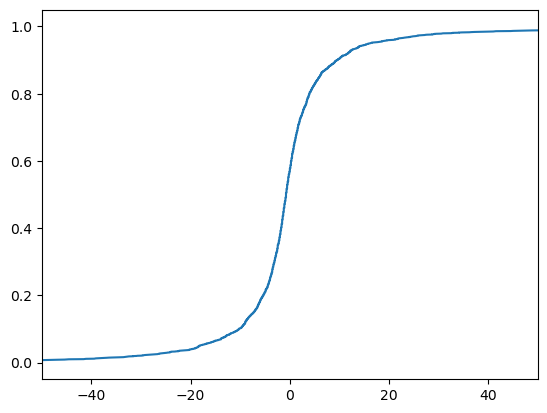

In [30]:
plt.plot(ecdf.x, ecdf.y)
plt.xlim(-50, 50)
plt.show()

In [31]:
from scipy.interpolate import interp1d

In [32]:
eppf = interp1d(ecdf.y, ecdf.x)

Calculate the critical fractile

In [33]:
price = 20
cost = 12
salvage = 8
over = cost - salvage
under = price - cost
critical_fractile = under / (over + under)
critical_fractile

0.6666666666666666

We offset our predictions for the test datasets by the $eppf(critical\_fractile)$ to get the optimal inventory level.

In [34]:
output_df['inventory'] = eppf(critical_fractile) + output_df['sales']

In [35]:
output_df[['sales', 'inventory']].head()

,sales,inventory
0,21.000000,22.111111
1,36.888889,38.000000
2,9.111111,10.222222
3,17.000000,18.111111
4,5.444444,6.555556


In [36]:
output_df.to_csv('data/output/predictions/knn.csv')